# Data Configuration

## Import packages & Basic settings

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
cd /gdrive/My Drive/img_dataset/img_dataset

/gdrive/My Drive/img_dataset/img_dataset


In [3]:
!pip install -q tf-nightly

     |████████████████████████████████| 109.1MB 186kB/s 
     |████████████████████████████████| 3.1MB 37.5MB/s 
     |████████████████████████████████| 491kB 51.0MB/s 
     |████████████████████████████████| 61kB 24.6MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [4]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
import os

import numpy as np

import matplotlib.pyplot as plt

keras = tf.keras
tf.VERSION


'1.14.1-dev20190511'

## Data preprocessing

In [5]:
import pathlib
import os

data_root=pathlib.Path('/gdrive/My Drive/img_dataset/img_dataset/celebs')
print(data_root)

/gdrive/My Drive/img_dataset/img_dataset/celebs


In [6]:
for item in data_root.iterdir():
  print(item)

/gdrive/My Drive/img_dataset/img_dataset/celebs/Arnold_Schwarzenegger
/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush
/gdrive/My Drive/img_dataset/img_dataset/celebs/Junichiro_Koizumi
/gdrive/My Drive/img_dataset/img_dataset/celebs/Tony_Blair
/gdrive/My Drive/img_dataset/img_dataset/celebs/Vladimir_Putin


In [7]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

img_count = len(all_image_paths)
img_count

825

## Check the images

In [8]:
all_image_paths[:10]

['/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0466.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0056.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0001.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/Junichiro_Koizumi/Junichiro_Koizumi_0008.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/Junichiro_Koizumi/Junichiro_Koizumi_0031.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0065.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/Junichiro_Koizumi/Junichiro_Koizumi_0043.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/Junichiro_Koizumi/Junichiro_Koizumi_0005.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0275.jpg',
 '/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0411.jpg']

In [0]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image : " + ' - '.join(str(image_rel).split('-'))
    

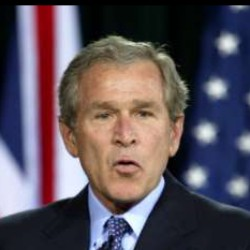

Image : George_W_Bush/George_W_Bush_0387.jpg



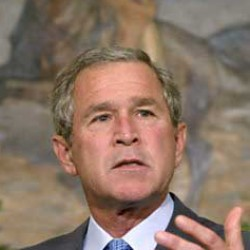

Image : George_W_Bush/George_W_Bush_0230.jpg



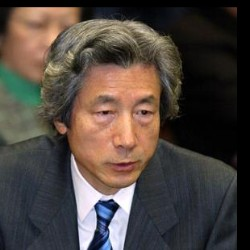

Image : Junichiro_Koizumi/Junichiro_Koizumi_0039.jpg



In [10]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [11]:
label_names= sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Arnold_Schwarzenegger',
 'George_W_Bush',
 'Junichiro_Koizumi',
 'Tony_Blair',
 'Vladimir_Putin']

In [12]:
label_to_index = dict((name,index)for index,name in enumerate(label_names))
label_to_index

{'Arnold_Schwarzenegger': 0,
 'George_W_Bush': 1,
 'Junichiro_Koizumi': 2,
 'Tony_Blair': 3,
 'Vladimir_Putin': 4}

In [13]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                   for path in all_image_paths]

print("First 10 labels indices : ", all_image_labels[:10])

First 10 labels indices :  [1, 1, 0, 2, 2, 1, 2, 2, 1, 1]


In [14]:
img_path = all_image_paths[0]
img_path

'/gdrive/My Drive/img_dataset/img_dataset/celebs/George_W_Bush/George_W_Bush_0466.jpg'

In [15]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [16]:
img_tensor =tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(250, 250, 3)
<dtype: 'uint8'>


In [17]:
img_final = tf.image.resize_images(img_tensor, [224, 224])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(224, 224, 3)
0.0
1.0


In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize_images(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

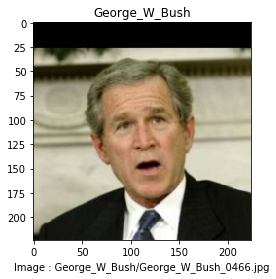

In [20]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [47]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

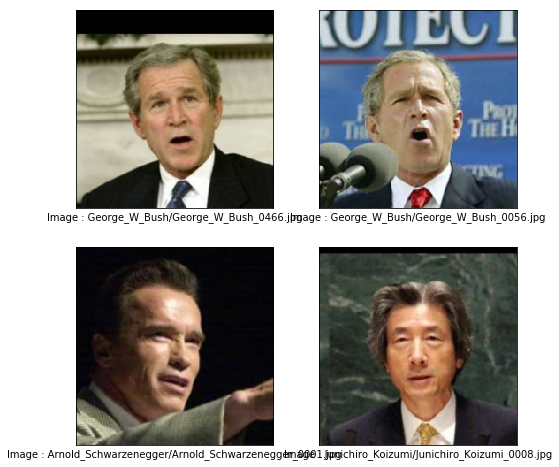

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))

In [0]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [54]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

George_W_Bush
George_W_Bush
Arnold_Schwarzenegger
Junichiro_Koizumi
Junichiro_Koizumi
George_W_Bush
Junichiro_Koizumi
Junichiro_Koizumi
George_W_Bush
George_W_Bush


In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [56]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (224, 224, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


## Dataset split

In [0]:
datalen=len(all_image_paths)*0.8

In [0]:
#split data set
train_ds = tf.data.Dataset.from_tensor_slices((all_image_paths[0:int(datalen*0.8)], all_image_labels[0:int(datalen*0.8)]))
val_ds = tf.data.Dataset.from_tensor_slices((all_image_paths[int(datalen*0.8):int(datalen)], all_image_labels[int(datalen*0.8):int(datalen)]))

# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

train_label_ds = train_ds.map(load_and_preprocess_from_path_label)
val_label_ds = train_ds.map(load_and_preprocess_from_path_label)
test_label_ds = test_ds.map(load_and_preprocess_from_path_label)

In [100]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
train_ds = train_ds.shuffle(buffer_size=img_count)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.shuffle(buffer_size=img_count)
val_ds = val_ds.repeat()
val_ds = val_ds.batch(BATCH_SIZE)



# `prefetch` lets the dataset fetch batches, in the background while the model is training.
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print(train_ds)
print(val_ds)

<DatasetV1Adapter shapes: ((?,), (?,)), types: (tf.string, tf.int32)>
<DatasetV1Adapter shapes: ((?,), (?,)), types: (tf.string, tf.int32)>


In [101]:
train_ds=train_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=int(img_count*0.8)))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
print(train_ds)
    
val_ds=val_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=int(img_count*0.2)))
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
print(val_ds)

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int32)>
<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int32)>


# Train phase

## Model setting

In [0]:
inception_net = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False)
inception_net.trainable=False

In [0]:
def chage_range(image,label):
    return 2*image-1, label
  
keras_ds =train_ds.map(chage_range)

In [0]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [119]:
feature_map_batch = inception_net(image_batch)
print(feature_map_batch.shape)

(32, 5, 5, 2048)


In [0]:
model = tf.keras.Sequential([
  inception_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [121]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -1.7315698
max logit: 2.3918393

Shape: (32, 5)


## Optimizer setting

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0005), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [128]:
len(model.trainable_variables) 

2

In [129]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [130]:
steps_per_epoch=tf.ceil(int(len(all_image_paths)*0.8)/BATCH_SIZE).numpy()
val_step=tf.ceil(int(len(all_image_paths)*0.2)/BATCH_SIZE).numpy()

print(steps_per_epoch)
initial_epochs=3

21.0


In [131]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds,
                    validation_steps=val_step,
                    )

Epoch 1/3
21/21 [==============================] - 105s 5s/step - loss: 3.5747 - acc: 0.5908 - val_loss: 3.9392 - val_acc: 0.6198
Epoch 2/3
21/21 [==============================] - 96s 5s/step - loss: 3.3782 - acc: 0.6354 - val_loss: 3.9485 - val_acc: 0.6250
Epoch 3/3
21/21 [==============================] - 95s 5s/step - loss: 3.4434 - acc: 0.6562 - val_loss: 3.9429 - val_acc: 0.6250


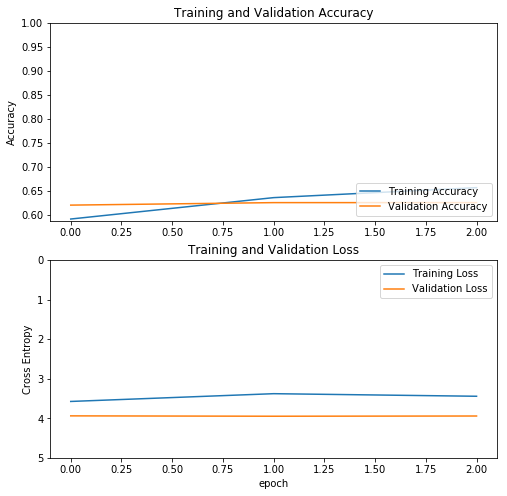

In [132]:
acc = history.history["acc"]
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([5,0.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Finetuning

In [165]:
inception_net.trainable =True
print("Number of layers in the base model :", len(inception_net.layers))

Number of layers in the base model : 311


In [0]:
fine_tune_at = 295

for layer in inception_net.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [168]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 405,509
Non-trainable params: 21,407,520
_________________________________________________________________


In [169]:
len(model.trainable_variables)

9

In [170]:
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                    epochs=total_epochs,
                    initial_epoch=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds,
                    validation_steps=val_step,
                    )

Epoch 4/6
21/21 [==============================] - 111s 5s/step - loss: 3.3703 - acc: 0.6488 - val_loss: 3.8113 - val_acc: 0.6250
Epoch 5/6
21/21 [==============================] - 96s 5s/step - loss: 3.1888 - acc: 0.6473 - val_loss: 4.1596 - val_acc: 0.6250
Epoch 6/6
21/21 [==============================] - 96s 5s/step - loss: 3.0829 - acc: 0.6637 - val_loss: 3.8173 - val_acc: 0.6250


In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

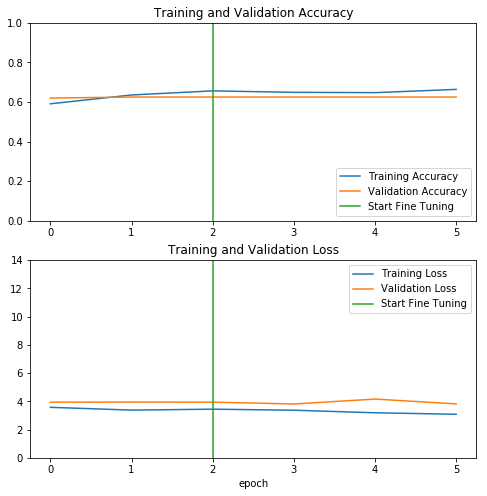

In [172]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 14])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save Phase

## Save tflite file

In [173]:
h5_file = "lienar.h5"
keras.models.save_model(model,h5_file)

Converter = tf.lite.TFLiteConverter.from_keras_model_file(h5_file)
tflite_model = Converter.convert()
open("linear.tflite","wb").write(tflite_model)

W0511 13:17:43.041574 140177969280896 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
W0511 13:17:46.937578 140177969280896 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


87161636

## To do

image augmentation<br>

cross validation<bt>
  
Tensor board <br>
